In [1]:
import numpy as np
from astropy.io import fits
from astropy.table import Table as Table
import matplotlib.pyplot as plt
from linetools.spectra import utils as ltsu
from linetools.spectra.xspectrum1d import XSpectrum1D
import astropy.units as u
from astropy import constants as const
from numpy import random as ran
%matplotlib notebook

### the same routine as clamato.read

In [2]:
z_bin = ([2.25,2.75])

path_17 = "/Users/jsmonzon/lbg_da/spectra/2017/"

spec_atr_17 = Table.read(path_17 + "spec_atr.txt", format='ascii')

In [3]:
spec_17 = []

z_17 = []

coord_17 = []

for entry in spec_atr_17:

    if np.min(z_bin) < entry["col5"] < np.max(z_bin):

        if entry["col4"] < 10.0:

            temp = XSpectrum1D.from_file(path_17 + entry["col1"])

            if temp.wvmin < (1120 * u.AA) * (1 + entry["col5"]) < temp.wvmax:

                coord_17.append([entry["col7"], entry["col8"]])  # coordinates in deg

                z_17.append(entry["col5"])

                spec_17.append(XSpectrum1D.from_file(path_17 + entry["col1"]))

 0"  ?      "?" 00$ ?(    ?               !        ?0    ((     (   !(!  ?"b??   [astropy.io.fits.card]
   !    a           "     `    `@   "  ` ? (  (       (        "  0          0   [astropy.io.fits.card]
        !    ?? , b         00?"0 $  0     ?       ?! "?   ?         (         0 [astropy.io.fits.card]
   $ `??    ?"?( `(`         !?!       ?*           d    ?  `!       0 "  $`! "  [astropy.io.fits.card]
  a 0 $I  ` !     ($   $ " (   (           !0 %`  "*`     ! $$       `  "  ?  "  [astropy.io.fits.card]
1@ `?      ?       ?  ?        $  (   "$   ? "!   "          !d (((    00` 0   [astropy.io.fits.card]
$?!   $  (  " *   `(  (  0  "0     `   0     !     D       !(   $!0      $?   ! [astropy.io.fits.card]
  0      ?!$"  !0    ?  0(          d !   0   &  !`"` ``           ?      ` (    [astropy.io.fits.card]
 $` $   "               (   !     j   $  $   `("       " $    &     ?    `  (    [astropy.io.fits.card]
   `  & "  `  P"   !   "    $     !? "!            0?``         

/opt/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:464: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


# Example Spec

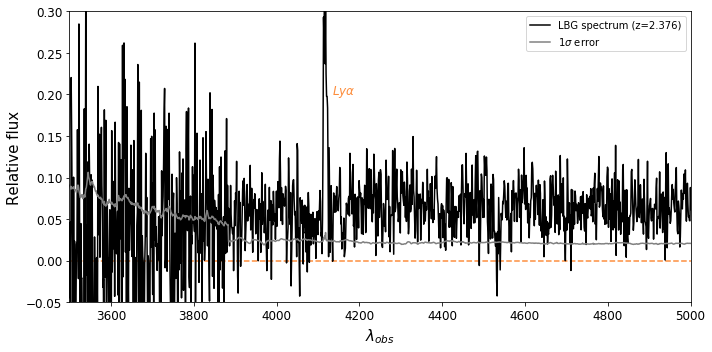

In [6]:
I = 14
red = z_17[I]

plt.figure(figsize=(10, 5), tight_layout=True)

plt.plot(spec_17[I].wavelength,spec_17[I].flux,color="black",label="LBG spectrum (z="+str(red)+")")
plt.plot(spec_17[I].wavelength,spec_17[I].sig, color="grey",label="1$\sigma$ error")

plt.hlines(0,3500,5000, color="#fd8d3c",linestyle="--")

plt.text(4135,.2,"$Lyα$",fontsize=12,color="#fd8d3c")

plt.xlabel("$\lambda_{obs}$",fontsize=15)
plt.ylabel("Relative flux",fontsize=15)

plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlim(3500,5000)
plt.ylim(-.05,.3)

plt.savefig("/Users/jsmonzon/lbg_da/figures/exspec.pdf")


plt.show()